<a href="https://colab.research.google.com/github/addicted-by/predictive_analysis/blob/main/Conv_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline for the anomaly detection on the SKAB using Convolutional Autoencoder

In [ ]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
import os
# from evaluating import evaluating_change_point

## Data loading

In [ ]:
fi = []
for root, dirs, files in os.walk("/content/SKAB/"):
    for file in files:
        if file.endswith(".csv"):
             fi.append(f'{root}/{file}')

In [ ]:
# !unzip ./drive/MyDrive/vvv/MM/archive.zip
# fi

In [ ]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in fi if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in fi if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data description and visualization

In [ ]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (1147, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-02-08 16:27:09,0.630939,0.722225,2.02547,0.382638,88.1308,29.5080,232.253,125.360,0.0,0.0
2020-02-08 16:27:10,0.629604,0.722420,2.50164,0.054711,88.6202,29.5098,244.806,125.322,0.0,0.0
2020-02-08 16:27:12,0.630294,0.720125,2.64764,0.054711,88.1902,29.5166,223.602,125.679,0.0,0.0
2020-02-08 16:27:13,0.625816,0.716048,2.64029,0.382638,88.1343,29.5299,229.358,126.000,0.0,0.0
2020-02-08 16:27:14,0.627160,0.722416,2.07664,0.054711,88.2831,29.5426,230.400,126.000,0.0,0.0


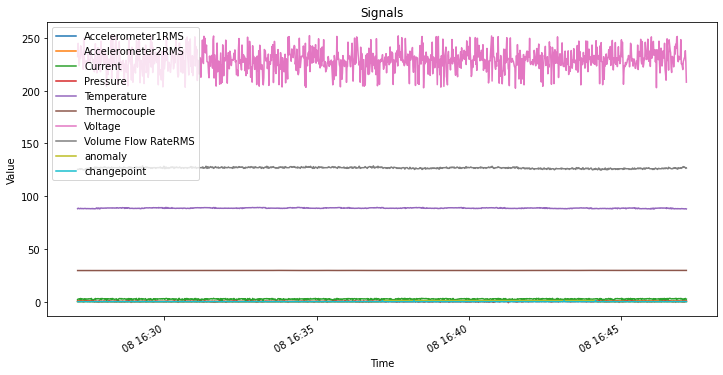

In [ ]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

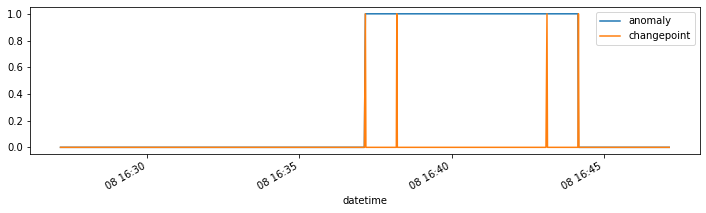

In [ ]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

In [ ]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

## Метрика F1

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model

In [ ]:
def arch(data):
    Random(0)
    model = keras.Sequential(
        [
            layers.Input(shape=(data.shape[1], data.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss="mse")
    # model.compile(optimizer=keras.optimizers.experimental.AdamW(learning_rate=0.001), loss="mse")

    # model.summary()

    history = model.fit(
        data,
        data,
        epochs=5000,
        batch_size=128,
        validation_split=0.2,
        verbose=1
        # metrics=[f1]#,
        # callbacks=[
        #     keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        # ],
    )
    return history, model

### Training in the beginning of each dataset

In [ ]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
type(list_of_df)

list

In [ ]:
# hyperparameters selection
N_STEPS = 60
Q = 0.75 # quantile for upper control limit (UCL) selection
from tqdm import tqdm
# inference
predicted_outlier, predicted_cp, out = [], [], []
for df in tqdm(list_of_df):
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model defining and fitting
    history, model = arch(X)
    out.append(history.history)   
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

  0%|          | 0/34 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 18ms/step - loss: 0.6903 - val_loss: 0.6966
Epoch 2502/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6903 - val_loss: 0.6966
Epoch 2503/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6902 - val_loss: 0.6962
Epoch 2504/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.6902 - val_loss: 0.6963
Epoch 2505/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.6902 - val_loss: 0.6963
Epoch 2506/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6901 - val_loss: 0.6962
Epoch 2507/5000
3/3 [==============================] - 0s 24ms/step - loss: 0.6903 - val_loss: 0.6963
Epoch 2508/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6901 - val_loss: 0.6964
Epoch 2509/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.6903 - val_loss: 0.6965
Epoch 2510/5000
3/3 [=========

  3%|▎         | 1/34 [04:28<2:27:45, 268.65s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 18ms/step - loss: 0.8482 - val_loss: 0.6455
Epoch 2502/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8482 - val_loss: 0.6457
Epoch 2503/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.8482 - val_loss: 0.6459
Epoch 2504/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8481 - val_loss: 0.6458
Epoch 2505/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8482 - val_loss: 0.6456
Epoch 2506/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8482 - val_loss: 0.6456
Epoch 2507/5000
3/3 [==============================] - 0s 20ms/step - loss: 0.8482 - val_loss: 0.6456
Epoch 2508/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8482 - val_loss: 0.6457
Epoch 2509/5000
3/3 [==============================] - 0s 20ms/step - loss: 0.8481 - val_loss: 0.6457
Epoch 2510/5000
3/3 [=========

  6%|▌         | 2/34 [08:58<2:23:31, 269.12s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 26ms/step - loss: 0.7657 - val_loss: 0.3678
Epoch 2502/5000
3/3 [==============================] - 0s 21ms/step - loss: 0.7657 - val_loss: 0.3673
Epoch 2503/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7652 - val_loss: 0.3674
Epoch 2504/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7657 - val_loss: 0.3678
Epoch 2505/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.7654 - val_loss: 0.3679
Epoch 2506/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7655 - val_loss: 0.3678
Epoch 2507/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7652 - val_loss: 0.3680
Epoch 2508/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7655 - val_loss: 0.3680
Epoch 2509/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.7653 - val_loss: 0.3678
Epoch 2510/5000
3/3 [=========

  9%|▉         | 3/34 [13:19<2:17:15, 265.67s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 18ms/step - loss: 0.8386 - val_loss: 0.7824
Epoch 2502/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8383 - val_loss: 0.7823
Epoch 2503/5000
3/3 [==============================] - 0s 21ms/step - loss: 0.8385 - val_loss: 0.7823
Epoch 2504/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.8384 - val_loss: 0.7823
Epoch 2505/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.8383 - val_loss: 0.7824
Epoch 2506/5000
3/3 [==============================] - 0s 23ms/step - loss: 0.8383 - val_loss: 0.7825
Epoch 2507/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.8385 - val_loss: 0.7825
Epoch 2508/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.8384 - val_loss: 0.7824
Epoch 2509/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.8383 - val_loss: 0.7824
Epoch 2510/5000
3/3 [=========

 12%|█▏        | 4/34 [17:43<2:12:29, 264.97s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 19ms/step - loss: 0.8082 - val_loss: 0.6048
Epoch 2502/5000
3/3 [==============================] - 0s 21ms/step - loss: 0.8080 - val_loss: 0.6049
Epoch 2503/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8080 - val_loss: 0.6045
Epoch 2504/5000
3/3 [==============================] - 0s 22ms/step - loss: 0.8081 - val_loss: 0.6043
Epoch 2505/5000
3/3 [==============================] - 0s 23ms/step - loss: 0.8082 - val_loss: 0.6043
Epoch 2506/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.8083 - val_loss: 0.6045
Epoch 2507/5000
3/3 [==============================] - 0s 21ms/step - loss: 0.8083 - val_loss: 0.6050
Epoch 2508/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8088 - val_loss: 0.6049
Epoch 2509/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.8082 - val_loss: 0.6046
Epoch 2510/5000
3/3 [=========

 15%|█▍        | 5/34 [23:07<2:18:17, 286.12s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 18ms/step - loss: 0.6486 - val_loss: 0.6315
Epoch 2502/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.6487 - val_loss: 0.6318
Epoch 2503/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6488 - val_loss: 0.6318
Epoch 2504/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6487 - val_loss: 0.6314
Epoch 2505/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6488 - val_loss: 0.6314
Epoch 2506/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6487 - val_loss: 0.6320
Epoch 2507/5000
3/3 [==============================] - 0s 17ms/step - loss: 0.6488 - val_loss: 0.6317
Epoch 2508/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6485 - val_loss: 0.6316
Epoch 2509/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.6488 - val_loss: 0.6315
Epoch 2510/5000
3/3 [=========

 18%|█▊        | 6/34 [27:29<2:09:48, 278.15s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
3/3 [==============================] - 0s 19ms/step - loss: 0.9003 - val_loss: 0.7819
Epoch 2330/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.9001 - val_loss: 0.7818
Epoch 2331/5000
3/3 [==============================] - 0s 24ms/step - loss: 0.9003 - val_loss: 0.7819
Epoch 2332/5000
3/3 [==============================] - 0s 18ms/step - loss: 0.9002 - val_loss: 0.7819
Epoch 2333/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.9002 - val_loss: 0.7819
Epoch 2334/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.9004 - val_loss: 0.7819
Epoch 2335/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.9002 - val_loss: 0.7821
Epoch 2336/5000
3/3 [==============================] - 0s 19ms/step - loss: 0.9003 - val_loss: 0.7821
Epoch 2337/5000
3/3 [==============================] - 0s 28ms/step - loss: 0.9004 - val_loss: 0.7821
Epoch 2338/5000
3/3 [=========

### Results

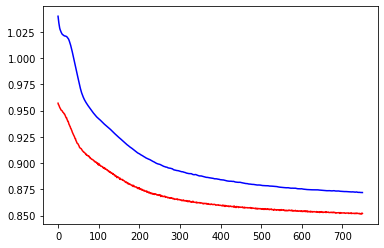

In [ ]:
plt.plot(history.history['val_loss'], label='val', color='blue')
plt.plot(history.history['loss'], label='train', color='red')

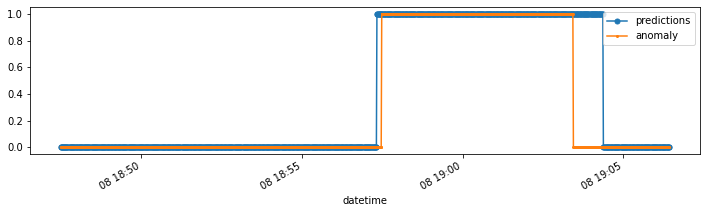

In [ ]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

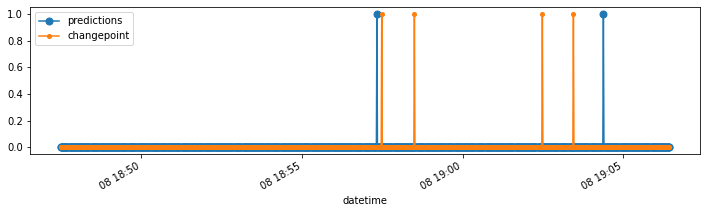

In [ ]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=7)
true_cp[1].plot(marker='o', markersize=4)
plt.legend();

## Metrics calculation

In [ ]:
import pandas as pd
import numpy as np

def evaluating_change_point(true, prediction, metric='nab', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true, prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ = true == 1 
            prediction_ = prediction == 1
            TP = (true_ & prediction_).sum()
            TN = (~true_ & ~prediction_).sum()
            FP = (~true_ & prediction_).sum()
            FN = (true_ & ~prediction_).sum()
            return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1
    
    def average_delay(detecting_boundaries, prediction):
        
        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory
            
        
        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        add = pd.Series(detectHistory).mean()
        print('Average delay', add)
        print(f'A number of missed CPs = {missing}')
        return add
    
    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics
        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1 
            is change point, and 0 in other case. 
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'
        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile 
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile             
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile  
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None, name_of_dataset=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores, Scores_perfect, Scores_null=[], [], []
            for profile in ['Standart', 'LowFP', 'LowFN']:       
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y, A_tp, A_fp, window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
                        print(f'Intersection of the windows of too wide widths for dataset {name_of_dataset}')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #to get the first index
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault), len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null), np.array(Scores_perfect)])
       #======      
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef,name_of_dataset=i)
                matrix = matrix + matrix_      
                
        results = {}
        desc = ['Standart', 'LowFP', 'LowFN'] 
        for t, profile_name in enumerate(desc):
            results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
            print(profile_name,' - ', results[profile_name])
        
        return results
            
            
    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]
        

    if not metric=='binary':
        def single_detecting_boundaries(true, numenta_time, true_items):
            detecting_boundaries=[]
            td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1]-true.index[0])/len(true_items))  
            for val in true_items:
                detecting_boundaries.append([val, val + td])
            return detecting_boundaries
        
        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true, numenta_time=numenta_time, true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i], numenta_time=numenta_time, true_items=true_items[i]))

    if metric== 'nab':
        return evaluate_nab(detecting_boundaries, prediction)
    elif metric=='average_delay':
        return average_delay(detecting_boundaries, prediction)
    elif metric== 'binary':
        return binary(true, prediction)

## coding

In [ ]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='60 sec')

False Alarm Rate 7.48 %
Missing Alarm Rate 30.92 %
F1 metric 0.76


In [ ]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:17.153846153
A number of missed CPs = 117


In [ ]:
# nab metric calculation
nab = evaluating_change_point(true_cp[1], predicted_cp[1], metric='binary', numenta_time='60 sec')

False Alarm Rate 0.19 %
Missing Alarm Rate 100.0 %
F1 metric 0.0


## ClearML

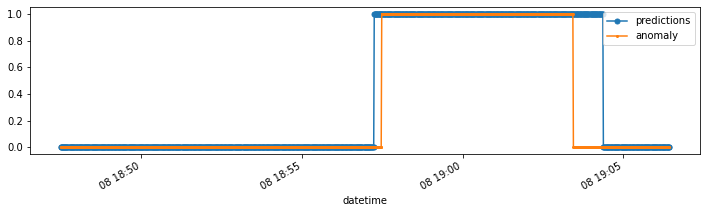

In [ ]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

In [ ]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='60 sec')

False Alarm Rate 7.7 %
Missing Alarm Rate 31.24 %
F1 metric 0.75
